In [1]:
import pandas as pd

# Load the uploaded dataset to examine it
file_path = 'credit_risk_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows and basic information about the dataset
data_info = data.info()
data_head = data.head()

# Summarize the dataset
data_summary = data.describe(include='all').transpose()

data_head, data_info, data_summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


(   person_age  person_income person_home_ownership  person_emp_length  \
 0          22          59000                  RENT              123.0   
 1          21           9600                   OWN                5.0   
 2          25           9600              MORTGAGE                1.0   
 3          23          65500                  RENT                4.0   
 4          24          54400                  RENT                8.0   
 
   loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
 0    PERSONAL          D      35000          16.02            1   
 1   EDUCATION          B       1000          11.14            0   
 2     MEDICAL          C       5500          12.87            1   
 3     MEDICAL          C      35000          15.23            1   
 4     MEDICAL          C      35000          14.27            1   
 
    loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
 0                 0.59                         Y               

Dataset Overview: Credit Risk
Dataset Shape: 32,581 rows and 12 columns

Missing Values:

person_emp_length has 895 missing values.
loan_int_rate has 3,116 missing values.

**EDA**

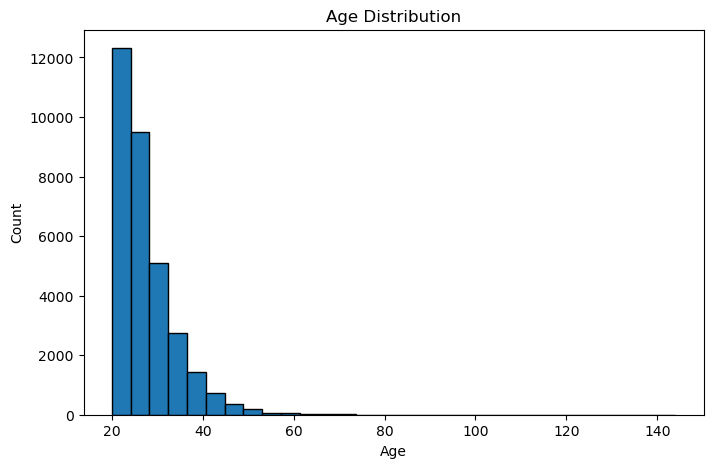

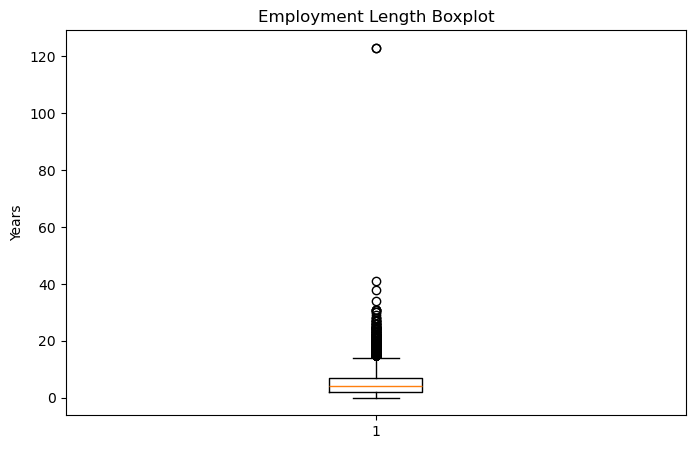

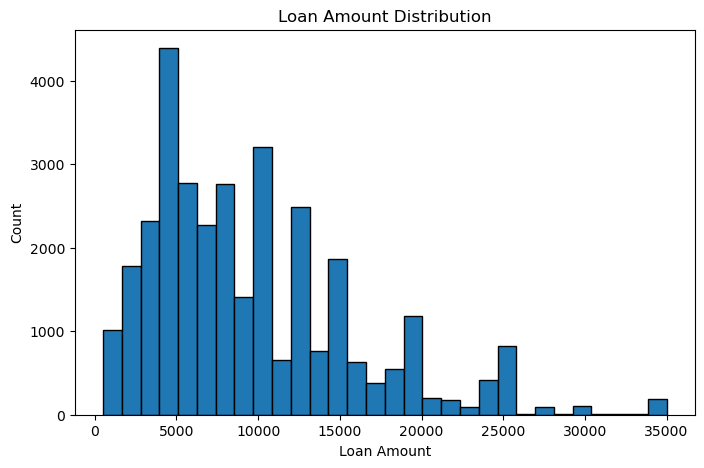

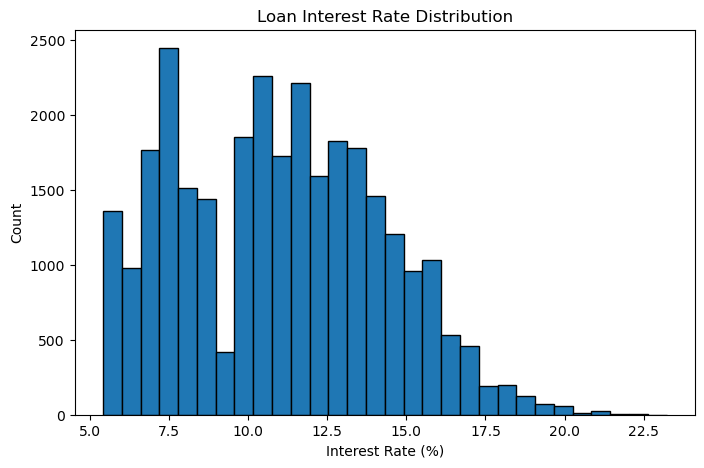

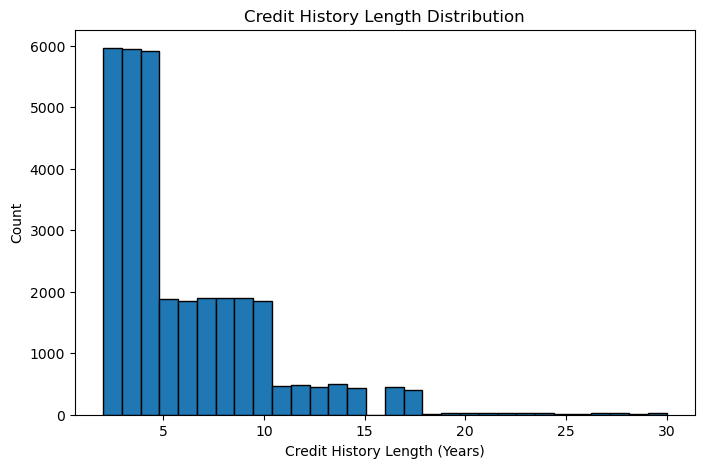

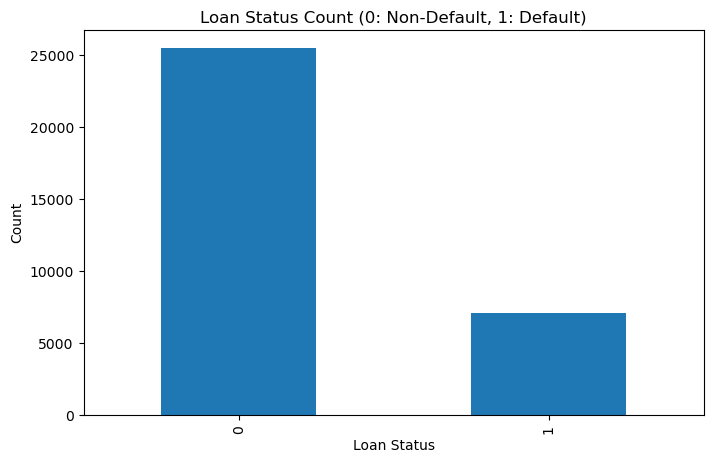

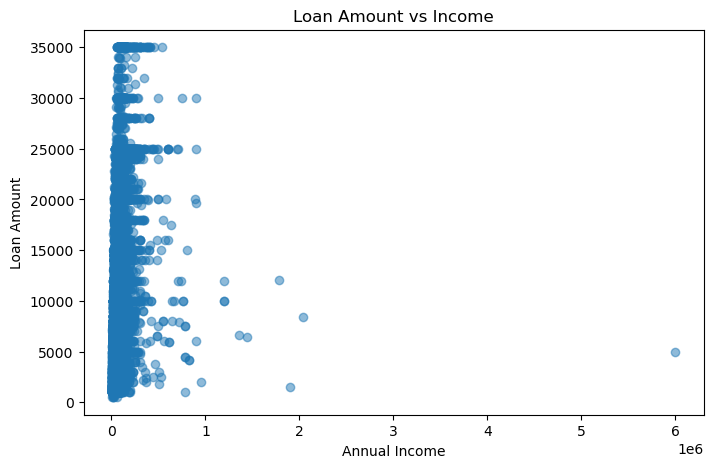

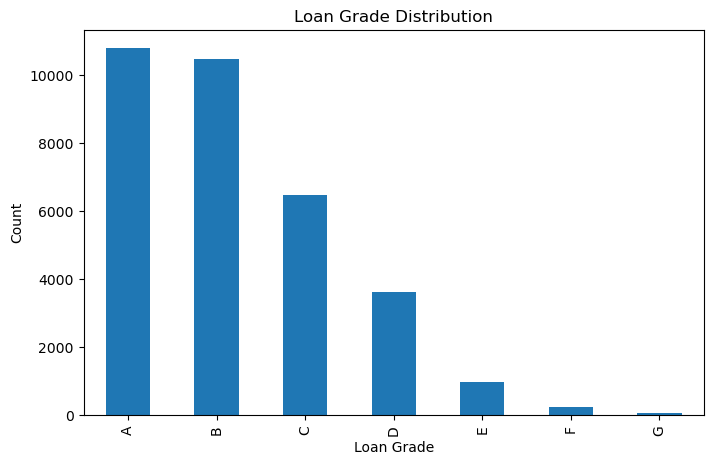

In [2]:
import matplotlib.pyplot as plt

# Define functions for plotting distributions and relationships
def plot_distribution(column_name, title, xlabel):
    plt.figure(figsize=(8, 5))
    plt.hist(data[column_name].dropna(), bins=30, edgecolor="k")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.show()

def plot_boxplot(column_name, title, ylabel):
    plt.figure(figsize=(8, 5))
    plt.boxplot(data[column_name].dropna())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

def plot_categorical_countplot(column_name, title, xlabel):
    plt.figure(figsize=(8, 5))
    data[column_name].value_counts().plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.show()

def plot_scatter(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 5))
    plt.scatter(data[x], data[y], alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Age Distribution
plot_distribution('person_age', 'Age Distribution', 'Age')

# Employment Length Boxplot (detecting outliers)
plot_boxplot('person_emp_length', 'Employment Length Boxplot', 'Years')

# Loan Amount Distribution
plot_distribution('loan_amnt', 'Loan Amount Distribution', 'Loan Amount')

# Loan Interest Rate Distribution
plot_distribution('loan_int_rate', 'Loan Interest Rate Distribution', 'Interest Rate (%)')

# Credit History Length Distribution
plot_distribution('cb_person_cred_hist_length', 'Credit History Length Distribution', 'Credit History Length (Years)')

# Loan Status Count (Default vs Non-default)
plot_categorical_countplot('loan_status', 'Loan Status Count (0: Non-Default, 1: Default)', 'Loan Status')

# Relationship Between Income and Loan Amount
plot_scatter('person_income', 'loan_amnt', 'Loan Amount vs Income', 'Annual Income', 'Loan Amount')

# Loan Grade Distribution
plot_categorical_countplot('loan_grade', 'Loan Grade Distribution', 'Loan Grade')


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Step 1: Split the data into train and test
X = data.drop(columns=['loan_status'])
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Create preprocessing pipeline to avoid data leakage
numeric_features = ['person_age', 'person_emp_length', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Impute and scale numeric features, one-hot encode categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 3: Define the model and pipeline
model = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Step 4: Perform hyperparameter tuning with cross-validation
param_distributions = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=10, 
                                   cv=5, scoring='accuracy', random_state=42, verbose=1, n_jobs=-1)

# Fit the random search on the training data
random_search.fit(X_train, y_train)

# Best model after cross-validation
best_model = random_search.best_estimator_

# Step 5: Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

accuracy, conf_matrix, class_report
